In [12]:
from torch_snippets import * 
from torchvision.datasets import MNIST 
from torchvision import transforms 
device = 'cuda' if torch.cuda.is_available () else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5],[0.5]), 
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('../public/data/', transform=img_transform, train=True, download=True)
val_ds = MNIST('../public/data/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


In [13]:
from turtle import forward


class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,3,stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,stride=2), 
            nn.Conv2d(32,64,3, stride=2, padding=1),
            nn.ReLU(True), 
            nn.MaxPool2d(2,stride=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,stride=2), 
            nn.ReLU(True), 
            nn.ConvTranspose2d(32,16,5,stride=3, padding=1),
            nn.ReLU(True), 
            nn.ConvTranspose2d(16,1,2,stride=2, padding=1), 
            nn.Tanh()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [14]:
model = ConvAutoEncoder().to(device)
from torchsummary import summary
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [15]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)


EPOCH: 1.000	trn_loss: 0.172	val_loss: 0.092	(19.70s - 78.81s remaining)
EPOCH: 2.000	trn_loss: 0.083	val_loss: 0.072	(38.25s - 57.38s remaining)
EPOCH: 3.000	trn_loss: 0.070	val_loss: 0.064	(56.84s - 37.90s remaining)
EPOCH: 4.000	trn_loss: 0.063	val_loss: 0.059	(75.58s - 18.90s remaining)
EPOCH: 5.000	trn_loss: 0.059	val_loss: 0.056	(94.23s - 0.00s remaining)


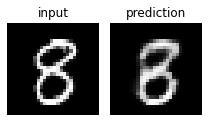

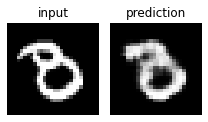

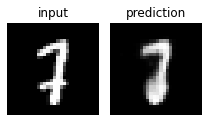

In [16]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()



In [17]:
# define path2weights
path2weights="../public/weights/weights.pt"
# store state_dict to file
torch.save(model.state_dict(), path2weights)
# define model: weights are randomly initiated
_model = model
weights=torch.load(path2weights)
_model.load_state_dict(weights)

# define a path2model
path2model="../public/models/model.pt"
# store model and weights into a file
torch.save(model,path2model)
# define model: weights are randomly initiated
_model = model
_model=torch.load(path2model)